# EECS 4422 Assignment 3

Jimmy Le<br>
216143992<br>
Prof. Kosta Derpanis<br>
EECS4422 W2023

## Tasks:

o Implement RANSAC based image stitching<br>
o Implement Panorama Construction<br>

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import cv2
import torch
import torch.nn as nn
import os
import kornia
import random
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #Prevents an unusual error where displaying images will crash the kernel?
#rcParams['figure.figsize'] = 11,8
plt.gray() #Ensures greyscale images are displayed gray without having to use cmap parameter

<Figure size 432x288 with 0 Axes>

## Functions

In [2]:
#Displays Tensors as image
def imshowTorch(input):
    image = kornia.tensor_to_image(input) #Converts to HWC format
    plt.imshow(image) #As matplotlib requires arrays 

In [3]:
#Converts numpy arrays to Kornia compatable tensors
def toKornia(img):
    print(img.shape)
    img = kornia.image_to_tensor(img) #Kornia in shape BCHW
    print(img.shape)
    # #Adding in dummy axis from: https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/
    img = torch.unsqueeze(img, dim=0)
    print(img.shape)
    return img

In [4]:
#Converts images to grayscale
# Implented during in class labs
def img2grayscale(img):
    # img = img.astype(np.float32)/255
    # img = (img[:,:,0]+ img[:,:,1]+ img[:,:,2]) / 3
    img_gr = img.copy()
    img_gr = cv2.cvtColor(img_gr, cv2.COLOR_RGB2GRAY)
    return img_gr

In [5]:
#Image padding implemented from in class Labs(#2,4)
# Source: https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape
def pad_images_to_same_size(images):
    """
    :param images: sequence of images
    :return: list of images padded so that all images have same width and height (max width and height are used)
    """
    width_max = 0
    height_max = 0
    for img in images:
        h, w = img.shape[:2]
        width_max = int(max(width_max, w) * 1.5)
        height_max = int(max(height_max, h) * 1.5)

    images_padded = []
    for img in images:
        h, w = img.shape[:2]
        diff_vert = height_max - h
        pad_top = diff_vert//2
        pad_bottom = diff_vert - pad_top
        diff_hori = width_max - w
        pad_left = diff_hori//2
        pad_right = diff_hori - pad_left
        img_padded = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=0)
        assert img_padded.shape[:2] == (height_max, width_max)
        images_padded.append(img_padded)

    return images_padded

In [6]:
def euclidan(pair, h):

    a1 = np.transpose([pair[0], pair[1], 1])
    estimate = np.dot(h, a1)
    #estimate = sum([x*y for x,y in zip(h, a1)])
    #print(estimate)
    estimate = estimate/estimate[2]

    a2 = np.transpose([pair[2], pair[3], 1])
    err = a2 - estimate
    return np.linalg.norm(err)

In [7]:
def homography(points):
    #points = np.reshape(points, (4,4))
    matrix = []
    #print(points)
    for p in points:
        #print(p)
        p1 = [p[0],p[1],1]
        p2 = [p[2],p[3],1]
        a1 = [-p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], 0, 0, 0, p2[0] * p1[0], p2[0] * p1[0], p2[0] * p1[2]]
        matrix.append(a1)
        a2 = [0, 0, 0, -p2[2] * p1[0], -p2[2] * p1[1], -p2[2] * p1[2], p2[1] * p1[0], p2[1] * p1[1], p2[1] * p1[2]]
        matrix.append(a2)
    
    matrix = np.asarray(matrix, dtype=float)
    u, s, v = np.linalg.svd(matrix)

    result = np.reshape(v[8], (3, 3))

    #print(type(result))
    result = (1/result[2][2]) * result
    #print(type(result))

    return result

In [8]:
import matplotlib.pyplot as plt
import numpy as np


# Provided code for plotting inlier matches between two images

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)


In [9]:
#Intuition: Kosta's lecture notes & provided example: tinyurl.com/RANSAC-demo (slide 456 of Feature Detection)
def RANSAC(matched,rho):
    
    bestModel = None
    #bestScore = Math.inf 
    bestInliers = []
    inliers = []
    #rand = random.randint(0, matched.shape[0]-1)
    #For a sufficent number of iterations   
    for i in range(2000):
        points = []
        points = [matched[random.randint(0, matched.shape[0]-1)] for k in range(4)]
        h = homography(points)
        #print(type(h))
        inliers = []
        for j in matched:
            d = euclidan(j,h)
            if d < 5:
                inliers.append(j)       
        if len(bestInliers) < len(inliers):
            bestInliers = inliers
            bestModel = h       
        if (len(matched)*rho) < len(bestInliers):
            break  
    return bestModel, bestInliers


## PART A

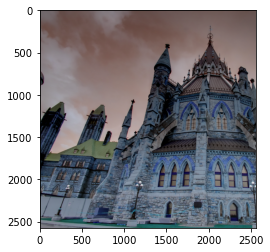

In [10]:
#Read in left
imgLeft = cv2.imread('parliament-left.jpg')
plt.imshow(imgLeft)

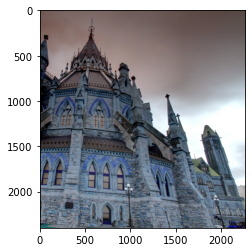

In [11]:
#Read in right
imgRight = cv2.imread('parliament-right.jpg')
plt.imshow(imgRight)

In [12]:
imgLeft, imgRight = pad_images_to_same_size([imgLeft, imgRight])

In [13]:
# imgLeft, imgRight = padImage(imgLeft, imgRight)

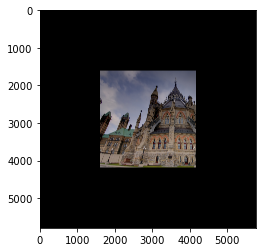

In [14]:
#Convert to rgb
imgLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2RGB)
plt.imshow(imgLeft)

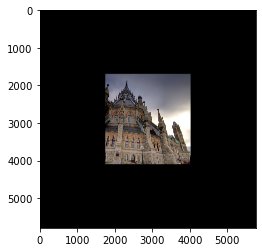

In [15]:
#Convert to rgb
imgRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2RGB)
plt.imshow(imgRight)

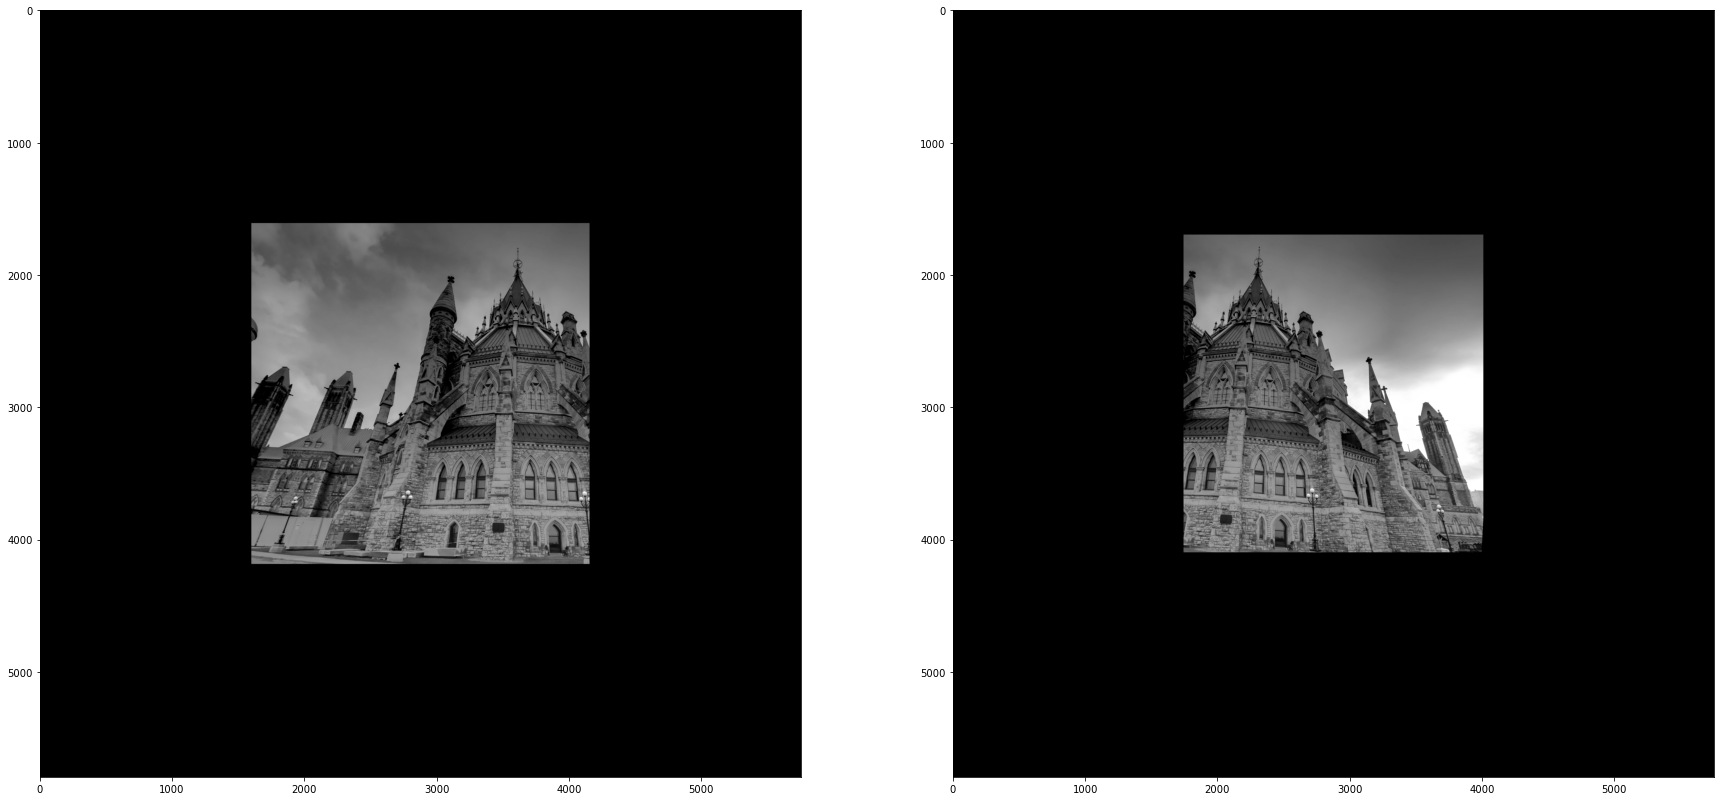

In [16]:
#Step 1, Convert images to grayscale
imgLeft_gr = img2grayscale(imgLeft)
imgRight_gr = img2grayscale(imgRight)
#Matplotlib subplots from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(1,2, figsize=(30,30))
ax[0].imshow(imgLeft_gr)
ax[1].imshow(imgRight_gr)

In [17]:
sift = cv2.SIFT_create()
kp_l, des_l = sift.detectAndCompute(imgLeft_gr,None)


In [18]:
imgLeft = imgLeft.astype(np.float32)/255 
imgRight = imgRight.astype(np.float32)/255 

In [19]:
imgLeft_k = toKornia(imgLeft)
imgRight_k = toKornia(imgRight)

(5793, 5751, 3)
torch.Size([3, 5793, 5751])
torch.Size([1, 3, 5793, 5751])
(5793, 5751, 3)
torch.Size([3, 5793, 5751])
torch.Size([1, 3, 5793, 5751])


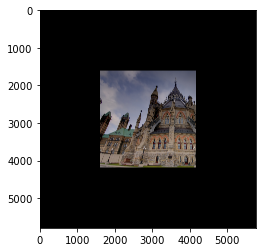

In [20]:
plt.imshow(imgLeft)


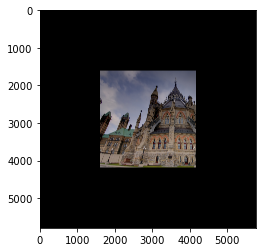

In [21]:
imshowTorch(imgLeft_k)


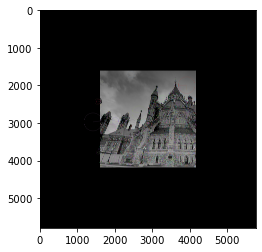

In [22]:
imgLeft_kp = imgLeft.copy()
imgLeft_kp=cv2.drawKeypoints(imgLeft_gr,kp_l,imgLeft_kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#cv2.imwrite('sift_keypoints.jpg',img)
plt.imshow(imgLeft_kp)

In [23]:
kp_r, des_r = sift.detectAndCompute(imgRight_gr,None)

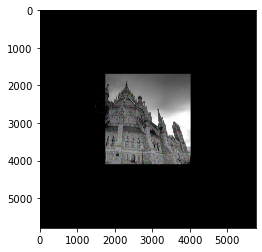

In [24]:
imgRight_kp = imgRight.copy()
imgRight_kp=cv2.drawKeypoints(imgRight_gr,kp_r,imgRight_kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#cv2.imwrite('sift_keypoints.jpg',img)
plt.imshow(imgRight_kp)

In [25]:
des_l_k = kornia.image_to_tensor(des_l)

In [26]:
des_l_k.shape

torch.Size([1, 16614, 128])

In [27]:
des_l_k = torch.squeeze(des_l_k)

In [28]:
des_l_k.shape

torch.Size([16614, 128])

In [29]:
des_r_k = kornia.image_to_tensor(des_r)
des_r_k = torch.squeeze(des_r_k)

In [30]:
des_r_k.shape

torch.Size([17832, 128])

In [31]:
bf = cv2.BFMatcher()
dis = bf.knnMatch(des_l, des_r, k=2) 
matched1, matched2 = kornia.feature.match_snn(des_l_k, des_r_k)

In [32]:
matched1[0]

tensor([0.7589])

In [33]:
#Step 4, apply thresholding (using threshold = 50)
thresholded = []
for i, j in dis:
    if i.distance < 0.75*j.distance:
        if i.distance < 50:
            thresholded.append([i])
            #thresholded.append([i, matched1[0], matched2[0]])

In [34]:
# #Step 4, apply thresholding (for kornia matched values)
# thresh = []
# for i, j in matched2:
#     if i < 0.75*j:
#         if i < 50:
#             thresh.append([i])

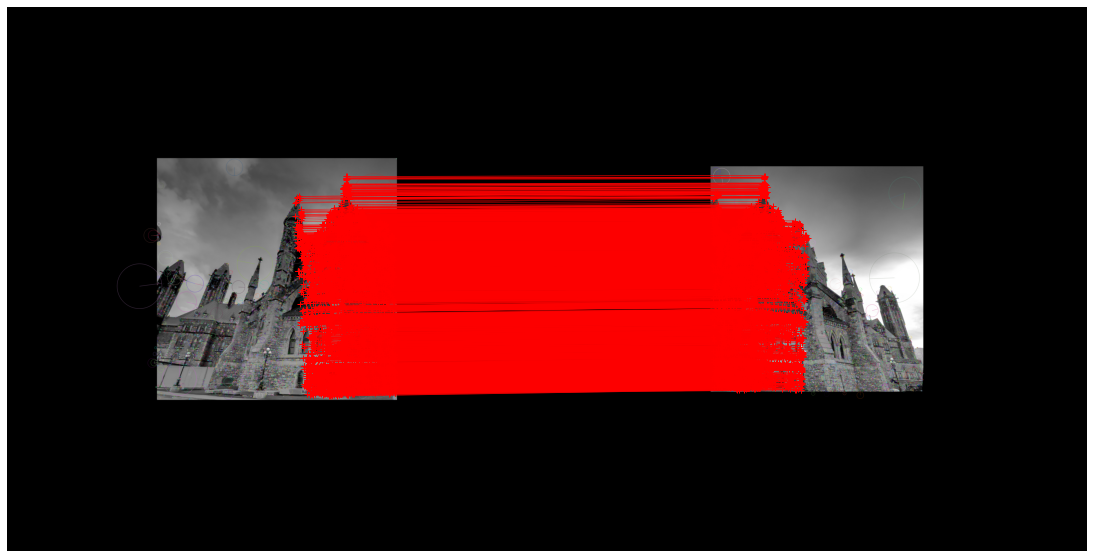

In [35]:
matched = []
for i in thresholded:
    imgLeft_Idx = i[0].queryIdx
    imgRight_Idx = i[0].trainIdx

    [a1,b1] = kp_l[imgLeft_Idx].pt
    [a2,b2] = kp_r[imgRight_Idx].pt
    matched.append([a1,b1,a2,b2])

matched = np.asarray(matched)

fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, imgLeft_kp, imgRight_kp, matched)


In [36]:
len(matched)

3956

In [37]:
matched.shape

(3956, 4)

In [38]:
#Implement/call ransac

In [39]:
matched.shape[0]

3956

In [40]:
points = []

In [41]:
points = [matched[random.randint(0, matched.shape[0]-1)] for i in range(4)]

In [42]:
points

[array([4101.36425781, 3965.62451172, 2683.70849609, 3934.92382812]),
 array([3447.06420898, 3245.08496094, 2080.58447266, 3196.44750977]),
 array([3340.19262695, 2408.23681641, 2018.90979004, 2372.33764648]),
 array([3553.47973633, 3843.53588867, 2154.01269531, 3787.43286133])]

In [43]:
points[2][0]

3340.192626953125

In [44]:
for i in matched:
    print(i)

[3067.63134766 2225.83300781 1761.83105469 2180.02416992]
[3068.66845703 2086.89282227 1769.76281738 2044.26574707]
[3072.76782227 2341.92651367 1760.68017578 2293.78686523]
[3073.86962891 2078.04907227 1775.40869141 2035.57592773]
[3081.55322266 2338.06518555 1769.50939941 2290.37060547]
[3083.51074219 2429.12597656 1766.66540527 2379.54467773]
[3083.51074219 2429.12597656 1766.66540527 2379.54467773]
[3083.91064453 2398.09643555 1768.7097168  2349.28222656]
[3084.37182617 2286.86328125 1774.95117188 2240.4753418 ]
[3085.59765625 2506.45922852 1764.75817871 2455.37451172]
[3086.46362305 2336.92504883 1774.42443848 2289.64404297]
[3086.64404297 2340.96533203 1774.38586426 2293.58129883]
[3088.23266602 2018.9954834  1792.44506836 1978.63452148]
[3089.50488281 2033.72192383 1792.80895996 1993.07983398]
[3092.39501953 2362.90136719 1778.8951416  2315.37915039]
[3092.94360352 2563.64428711 1769.04223633 2511.62744141]
[3093.10327148 2469.72265625 1773.99951172 2419.80224609]
[3096.9465332 

In [45]:
# bestModel = None
# #bestScore = Math.inf 
# bestInliers = []
# inliers = []
# #rand = random.randint(0, matched.shape[0]-1)
# #For a sufficent number of iterations   
# for i in range(2000):
#     points = []
#     points = [matched[random.randint(0, matched.shape[0]-1)] for k in range(4)]
#     h = affine(points)
#     #print(type(h))
#     inliers = []

#     for j in matched:
#         d = euclidan(j,h)
#         if d < 5:
#             inliers.append(j)
    
#     if len(inliers) > len(bestInliers):
#         bestInliers = inliers
#         bestModel = h

#     if len(bestInliers) > (len(matched)*0.05):
#         break

In [46]:
bestModel, bestInliers = RANSAC(matched, 0.05)

In [47]:
#h, inliers = RANSAC(matched,.05)

In [48]:
bestModel

array([[ 9.82665844e-01, -5.14227045e-02, -1.13463475e+03],
       [ 5.23613601e-02,  9.81607095e-01, -1.61542967e+02],
       [ 3.75401209e-07,  3.55211263e-07,  1.00000000e+00]])

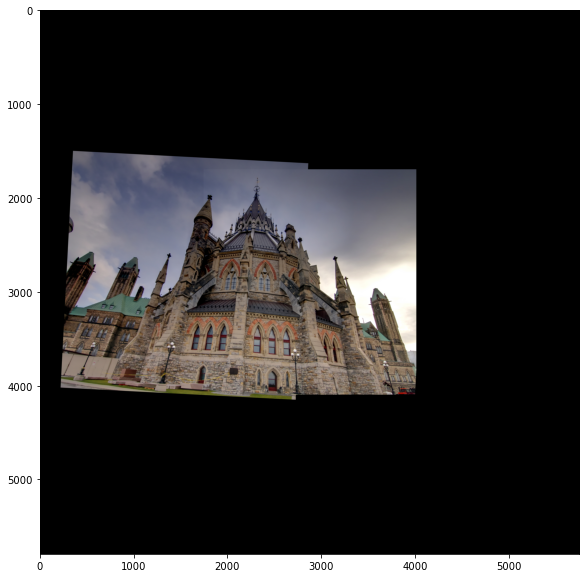

In [51]:
k = torch.tensor(bestModel, dtype = torch.float)
k = k.unsqueeze(0)
(h,w) = imgLeft_k.shape[2:]
out = kornia.geometry.warp_perspective(imgLeft_k,k,(h,w))
max = torch.max(out,imgRight_k)
plt.figure(figsize=(10,10))
imshowTorch(max)


## Part B